In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import radical.pilot as rp
import radical.utils as ru
import radical.analytics as ra
from radical.entk import Profiler
import numpy as np
from math import sqrt
import pandas as pd

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
FONTSIZE = SIZE
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y))
    
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
        for ax1 in axes:
            for ax2 in ax1:
                ax2.get_xaxis().tick_bottom()  
                ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
        for ax1 in axes:
            for ax2 in ax1:
                ax2.get_xaxis().tick_bottom()  
                ax2.get_yaxis().tick_left()
    return fig, axes

In [3]:
# Profile analysis

data_loc = '../raw_data'
ensemble_size = 16
iters = 5
json_files = glob.glob('{0}/trial_1/rp.*/*.json'.format(data_loc))
json_file = json_files[0]
json      = ru.read_json(json_file)
sid       = os.path.basename(json_file)[:-5]

session = ra.Session(stype='radical.pilot', src=os.path.dirname(json_file))
units = session.filter(etype='unit', inplace=False)
uids = sorted(units.list('uid'))

assert len(uids) == 1 + 3*ensemble_size*iters
flag = len(uids) == 1 + 3*ensemble_size*iters
df_prof = pd.DataFrame(columns=['grompp','mdrun','post-analysis'])

if flag:
    for t in range(iters):
        offset = ensemble_size*3*t
        grompp = units.filter(uid=uids[1+offset:17+offset]).duration(event=[{ru.EVENT: 'cu_exec_start'}, {ru.EVENT: 'cu_exec_stop'}])
        units = session.filter(etype='unit', inplace=False)
        mdrun = units.filter(uid=uids[17+offset:33+offset]).duration(event=[{ru.EVENT: 'cu_exec_start'}, {ru.EVENT: 'cu_exec_stop'}])
        units = session.filter(etype='unit', inplace=False)
        post = units.filter(uid=uids[33+offset:49+offset]).duration(event=[{ru.EVENT: 'cu_exec_start'}, {ru.EVENT: 'cu_exec_stop'}])
        units = session.filter(etype='unit', inplace=False)
        
        df_prof.loc['Iter %s'%(t+1)] = [grompp, mdrun, post]
        
# display(df_prof)

In [4]:
def get_Toverlap(ranges):
    '''
    Helper function to create the list of lists from which to calculate the
    overlap of the elements of a DataFrame between the two boundaries passed as
    arguments.
    '''

    overlap = 0

    for crange in collapse_ranges(ranges):
        overlap += crange[1] - crange[0]

    return overlap

def collapse_ranges(ranges):
    """
    given be a set of ranges (as a set of pairs of floats [start, end] with
    'start <= end'. This algorithm will then collapse that set into the
    smallest possible set of ranges which cover the same, but not more nor
    less, of the domain (floats).

    We first sort the ranges by their starting point. We then start with the
    range with the smallest starting point [start_1, end_1], and compare to the
    next following range [start_2, end_2], where we now know that start_1 <=
    start_2. We have now two cases:

    a) when start_2 <= end_1, then the ranges overlap, and we collapse them
    into range_1: range_1 = [start_1, max[end_1, end_2]

    b) when start_2 > end_2, then ranges don't overlap. Importantly, none of
    the other later ranges can ever overlap range_1. So we move range_1 to
    the set of final ranges, and restart the algorithm with range_2 being
    the smallest one.

    Termination condition is if only one range is left -- it is also moved to
    the list of final ranges then, and that list is returned.
    """

    final = []

    # sort ranges into a copy list
    _ranges = sorted (ranges, key=lambda x: x[0])

    START = 0
    END = 1

    base = _ranges[0] # smallest range

    for _range in _ranges[1:]:

        if _range[START] <= base[END]:

            # ranges overlap -- extend the base
            base[END] = max(base[END], _range[END])

        else:

            # ranges don't overlap -- move base to final, and current _range
            # becomes the new base
            final.append(base)
            base = _range

    # termination: push last base to final
    final.append(base)

    return final

def get_duration(units):
    
    import numpy as np
    import time, datetime
    durs = []
    for unit in units:
        log = [x for x in glob.glob(unit + '/*') if x.endswith('.log')]
        if log:
            start = open(log[0],'r').readlines()[0]
            start_str = ' '.join(start.split()[4:])
            start_epoch = time.mktime(time.strptime(start_str, "%a %b %d %H:%M:%S %Y"))
            stop = open(log[0],'r').readlines()[-1]
            stop_str = ' '.join(stop.split()[5:])
            stop_epoch = time.mktime(time.strptime(stop_str, "%a %b %d %H:%M:%S %Y"))
            durs.append([start_epoch, stop_epoch])
        else:
            prof = open([x for x in glob.glob(unit + '/*') if x.endswith('.prof')][0],'r').readlines()
            start = float([x for x in prof if 'cu_exec_start' in x][0].split(',')[0])
            stop = float([x for x in prof if 'cu_exec_stop' in x][0].split(',')[0])
            durs.append([start, stop])
    
#     print durs
    return get_Toverlap(durs)

In [5]:
# Gromacs log analysis
data_loc = '../raw_data'
ensemble_size = 16
iters = 5
units = sorted(glob.glob('{0}/trial_1/units/unit.0*'.format(data_loc)))

assert len(units) == 1 + 3*ensemble_size*iters
flag = len(units) == 1 + 3*ensemble_size*iters
df_logs = pd.DataFrame(columns=['grompp','mdrun','post-analysis'])

for t in range(iters):
    
    offset = ensemble_size*3*t
    grompp = get_duration(units[1+offset:17+offset])
    mdrun = get_duration(units[17+offset:33+offset])
    post = get_duration(units[33+offset:49+offset])

    df_logs.loc['Iter %s'%(t+1)] = [grompp, mdrun, post]

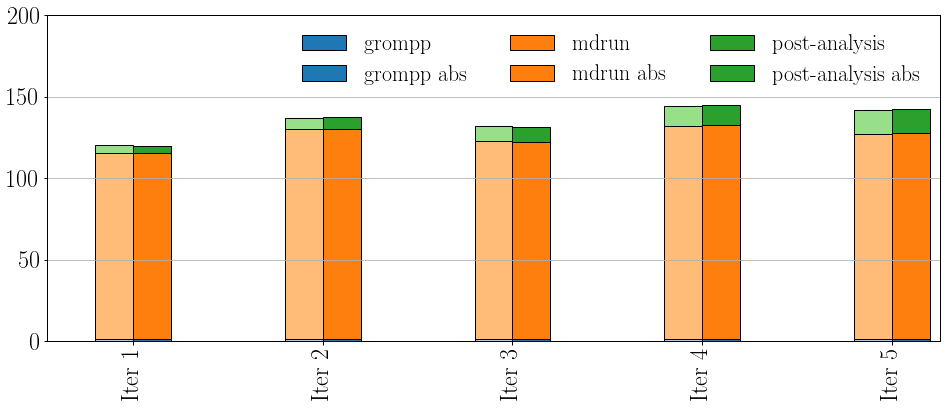

In [30]:
fig, axis = fig_setup(1,1, (16,6))

ax1 = df_logs.plot(kind='bar', 
             stacked=True,
             width=0.2,
             ax=axis[0][0],
             colors = [tableau20[0], tableau20[2], tableau20[4]],
             legend=False,
             ylim=(0,200),
             position=0)

ax2 = df_prof.plot(kind='bar', 
             stacked=True,
             width=0.2,
             ax=axis[0][0],
             colors = [tableau20[1], tableau20[3], tableau20[5]],
             legend=False,
             ylim=(0,200),
             position=1)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

l2 = [str(l) + ' abs' for l in l2]

labels = [l1[0], l2[0], l1[1], l2[1], l1[2], l2[2]]
handles = [h1[0], h2[0], h1[1], h2[1], h1[2], h2[2]]

plt.legend(handles, labels, ncol=3)
plt.grid(axis='y')

In [26]:
df_diff = df_prof - df_logs
display(df_diff)

,grompp,mdrun,post-analysis
Iter 1,-0.000044,0.0851,-6.389618e-05
Iter 2,-0.000028,-0.1411,-7.152557e-07
Iter 3,0.000052,0.4811,-5.817413e-05
Iter 4,0.000116,-0.5924,2.074242e-05
Iter 5,-0.000048,-0.2232,-4.410744e-05


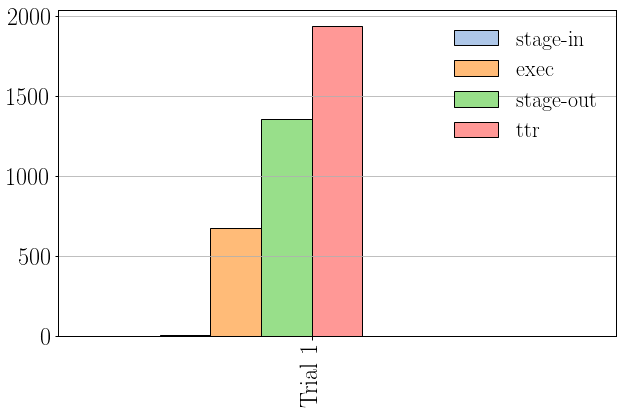

In [49]:
data_loc = '../raw_data'
ensemble_size = 16
iters = 5
json_files = glob.glob('{0}/trial_1/rp.*/*.json'.format(data_loc))
json_file = json_files[0]
json      = ru.read_json(json_file)
sid       = os.path.basename(json_file)[:-5]

session = ra.Session(stype='radical.pilot', src=os.path.dirname(json_file))
units = session.filter(etype='unit', inplace=False)
pilot = session.filter(etype='pilot', inplace=False)

df = pd.DataFrame(columns=['exec', 'stage-in', 'stage-out','ttr'])
exe = units.duration(event=[{ru.EVENT: 'cu_exec_start'}, {ru.EVENT: 'cu_exec_stop'}])
stage_in = units.duration(event=[{ru.EVENT: 'staging_in_start'}, {ru.EVENT: 'staging_in_stop'}])
stage_out = units.duration(event=[{ru.EVENT: 'staging_out_start'}, {ru.EVENT: 'staging_out_stop'}])
ttr = pilot.duration(state =[rp.PMGR_ACTIVE, rp.FINAL])
df.loc['Trial 1'] = [exe, stage_in, stage_out, ttr]

fig, axis = fig_setup(1,1, (10,6))
ax1 = df[['stage-in', 'exec', 'stage-out']].plot(ax=axis[0][0],
                                              kind='bar',
#                                               stacked=True,
                                              width=0.15,
                                              position=1,
                                              colors = [tableau20[1], tableau20[3], tableau20[5]],
                                              legend=False)
ax2 = df[['ttr']].plot(ax=axis[0][0],
                      kind='bar',
                      width=0.05,
                      position=0,
                      colors = [tableau20[7]],
                      legend=False)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

labels = l1 
handles = h1

plt.legend(handles, labels, ncol=1)
plt.grid(axis='y')